# Prosumer Energy Prediction

Il termine "prosumer" è un portmanteau che combina le parole "producer" (produttore) e "consumer" (consumatore). Il concetto di prosumer si riferisce a individui o entità che non sono soltanto consumatori di prodotti e servizi, ma anche produttori degli stessi. Questo fenomeno è cresciuto considerevolmente con l'avvento di Internet e delle tecnologie digitali, che hanno reso più facile per le persone non solo consumare contenuti, ma anche crearli e condividerli.

Nel contesto dell'energia, il termine "prosumer" assume una particolare rilevanza con riferimento a quelle persone o aziende che producono energia—tipicamente da fonti rinnovabili come il solare o l'eolico—per il proprio uso e vendono l'eccesso alla rete elettrica. Questo è diventato più accessibile grazie alla diminuzione dei costi delle tecnologie rinnovabili e alla maggiore disponibilità di opzioni per il finanziamento. I prosumer in questo settore sono quindi attori chiave nella transizione verso sistemi energetici più distribuiti e sostenibili, contribuendo alla riduzione delle emissioni di gas serra e alla promozione di un'economia circolare.

In un contesto sociale e economico più ampio, il concetto di prosumer rappresenta un cambio di paradigma rispetto al modello tradizionale di produzione e consumo. Invece di essere passivi consumatori, i prosumer sono attivamente coinvolti nel processo di creazione di valore, che può portare a nuovi modelli di business, a una maggiore personalizzazione dei prodotti e servizi e a una maggiore enfasi sulla sostenibilità.


*We PROduce and conSUME our output, we are prosuming. Prosuming purpose is to Share.*

Currently, in most countries, energy systems are transitioning from a centralized to a distributed model, and in the long-term, they are foreseen as smart and connected models using advanced emerging information technologies, called the energy Internet (EI). This change of model was already envisioned, proving that any electric power system, irrespective of size, can be modelled as a prosumer, defined as an economically motivated entity that consumes, produces, and stores power; operates a power grid; and optimizes the economic decisions regarding its energy utilization.

## Import LIBs and Data

In [1]:
import pandas as pd
import numpy as np

# Visualization Libraries 📊
# ------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Customize to Remove Warnings and Better Observation 🔧
# --------------------------------------------------------
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 300)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
train = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/train.csv')
test = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/example_test_files/test.csv')
submission = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/example_test_files/sample_submission.csv')
forecast_weather = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/forecast_weather.csv')
historical_weather = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/historical_weather.csv')
client = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/client.csv')
elec_prices = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/electricity_prices.csv')
gas_prices = pd.read_csv('C:/Users/giaco/Desktop/repos/prosumer-energy-prediction/data/gas_prices.csv')

## Useful Functions

In [23]:
def check_df(dataframe):
    print("----------------- SHAPE -----------------")
    print(dataframe.shape)
    print("----------------- INFO -----------------")
    print(dataframe.info())
    print("----------------- NA -----------------")
    print(dataframe.isnull().sum())

In [24]:
def corr_map(train, width=14, height=8, annot_kws=15):
    mtx = np.triu(features.corr())
    f, ax = plt.subplots(figsize = (width,height))
    sns.heatmap(train.corr(),
                annot= True,
                fmt = ".2f",
                ax=ax,
                vmin = -1,
                vmax = 1,
                cmap = "summer",
                mask = mtx,
                linewidth = 0.4,
                linecolor = "black",
                cbar=False,
                annot_kws={"size": annot_kws})
    plt.yticks(rotation=0,size=15)
    plt.xticks(rotation=75,size=15)
    plt.title('\nCorrelation Map\n', size = 20)
    plt.show();

In [26]:
def missing_values_table(dataframe, na_name = False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [28]:
def duplicated_rows(dataframe, head=5, report=True, dup_idx=False, drop_dup=False):
    if report:
        df_dup = train[train.duplicated()]
        print(f"Number of Duplicated Rows: {df_dup.shape[0]}\n")
        print(f"Duplicated first {head} Rows:")
        display(df_dup.head(head))
    
    if dup_idx:
        return df_dup.index

    if drop_dup:
        dataframe = dataframe.drop(df_dup.index, axis=0)
        return dataframe

## Data Exploration

TRAIN AND TEST DATAFRAMES

In [8]:
print("The shape of the TRAIN df is:")
print(train.shape)
train.head()

The shape of the TRAIN df is:
(2018352, 9)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


- `county` - An ID code for the county (contea).
- `is_business` - Boolean for whether or not the prosumer is a business.
- `product_type` - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- `target` - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- `is_consumption` - Boolean for whether or not this row's target is consumption or production.
- `datetime` - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- `data_block_id` - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- `row_id` - A unique identifier for the row.
- `prediction_unit_id` - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or dissappear in the test set.

In [12]:
print("The shape of the TEST df is:")
print(test.shape)
test.head()

The shape of the TEST df is:
(12480, 8)


,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2


SUBMISSION DATAFRAME

In [16]:
print(submission.shape)
submission.head()

(12480, 3)


,row_id,data_block_id,target
0,2005872,634,0
1,2005873,634,0
2,2005874,634,0
3,2005875,634,0
4,2005876,634,0


GAS_PRICES DATAFRAME

In [3]:
print("The shape of the GAS_PRICES df is:")
print(gas_prices.shape)
gas_prices.head()

The shape of the GAS_PRICES df is:
(637, 5)


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.230,46.320,2021-08-31,1
1,2021-09-02,45.620,46.290,2021-09-01,2
2,2021-09-03,45.850,46.400,2021-09-02,3
3,2021-09-04,46.300,46.800,2021-09-03,4
4,2021-09-05,46.300,46.580,2021-09-04,5


- `origin_date` - The date when the day-ahead prices became available.
- `forecast_date` - The date when the forecast prices should be relevant.
- `[lowest/highest]_price_per_mwh` - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
- `data_block_id`

ELECTRICITY PRICES DATAFRAME

In [4]:
print("The shape of the ELECTRICITY_PRICES df is:")
print(elec_prices.shape)
elec_prices.head()

The shape of the ELECTRICITY_PRICES df is:
(15286, 4)


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.510,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.900,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.350,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.880,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.430,2021-08-31 04:00:00,1


- `origin_date` - The date when the day-ahead prices became available.
- `forecast_date` - The date when the forecast prices should be relevant.
- `euros_per_mwh` - The price of electricity on the day ahead markets in euros per megawatt hour.
- `data_block_id`

CLIENT DATAFRAME

In [5]:
print("The shape of the CLIENT df is:")
print(client.shape)
client.head()

The shape of the CLIENT df is:
(41919, 7)


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.890,0,2021-09-01,2
1,2,0,17,166.400,0,2021-09-01,2
2,3,0,688,7207.880,0,2021-09-01,2
3,0,0,5,400.000,1,2021-09-01,2
4,1,0,43,1411.000,1,2021-09-01,2


- `product_type`
- `county` - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
- `eic_count` - The aggregated number of consumption points (EICs - European Identifier Code).
- `installed_capacity` - Installed photovoltaic solar panel capacity in kilowatts.
- `is_business` - Boolean for whether or not the prosumer is a business.
- `date`
- `data_block_id`

FORECAST WEATHER DATAFRAME

Weather forecasts that would have been available at prediction time. Sourced from the European Centre for Medium-Range Weather Forecasts.

In [8]:
print("The shape of the FORECAST WEATHER df is:")
print(forecast_weather.shape)
forecast_weather.head()

The shape of the FORECAST WEATHER df is:
(3424512, 18)


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.600,21.700,2021-09-01 00:00:00+00:00,1,15.656,11.554,0.905,0.020,0.000,0.906,-0.411,-9.106,1,2021-09-01 01:00:00+00:00,0.000,0.000,0.000,0.000
1,57.600,22.200,2021-09-01 00:00:00+00:00,1,13.004,10.690,0.886,0.004,0.000,0.887,0.206,-5.355,1,2021-09-01 01:00:00+00:00,0.000,0.000,0.000,0.000
2,57.600,22.700,2021-09-01 00:00:00+00:00,1,14.207,11.672,0.729,0.006,0.000,0.730,1.452,-7.418,1,2021-09-01 01:00:00+00:00,0.000,0.000,0.000,0.000
3,57.600,23.200,2021-09-01 00:00:00+00:00,1,14.845,12.265,0.336,0.074,0.001,0.385,1.091,-9.164,1,2021-09-01 01:00:00+00:00,0.000,0.000,0.000,0.000
4,57.600,23.700,2021-09-01 00:00:00+00:00,1,15.294,12.459,0.103,0.088,0.000,0.177,1.268,-8.976,1,2021-09-01 01:00:00+00:00,0.000,0.000,0.000,0.000


- `[latitude/longitude]` - The coordinates of the weather forecast.
- `origin_datetime` - The timestamp of when the forecast was generated.
- `hours_ahead` - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
- `temperature` - The air temperature at 2 meters above ground in degrees Celsius.
- `dewpoint` - The dew point temperature at 2 meters above ground in degrees Celsius.
- `cloudcover_[low/mid/high/total]` - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total.
- `10_metre_[u/v]_wind_component` - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second.
- `data_block_id`
- `forecast_datetime` - The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead.
- `direct_solar_radiation` - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the preceding hour, in watt-hours per square meter.
- `surface_solar_radiation_downwards` - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, in watt-hours per square meter.
- `snowfall` - Snowfall over the previous hour in units of meters of water equivalent.
- `total_precipitation` - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the preceding hour, in units of meters.

HISTORICAL WEATHER DATAFRAME

In [9]:
print("The shape of the HISTORICAL WEATHER df is:")
print(historical_weather.shape)
historical_weather.head()

The shape of the HISTORICAL WEATHER df is:
(1710800, 18)


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.400,12.000,0.000,0.000,1015.800,4,4,0,0,6.694,3,0.000,0.000,0.000,57.600,21.700,1
1,2021-09-01 00:00:00,14.400,12.000,0.000,0.000,1015.800,4,4,0,0,6.694,3,0.000,0.000,0.000,57.600,21.700,1
2,2021-09-01 00:00:00,14.000,12.000,0.000,0.000,1010.600,7,8,0,0,4.944,353,0.000,0.000,0.000,57.600,22.200,1
3,2021-09-01 00:00:00,14.400,12.800,0.000,0.000,1014.900,6,7,0,0,5.833,348,0.000,0.000,0.000,57.600,22.700,1
4,2021-09-01 00:00:00,14.400,12.800,0.000,0.000,1014.900,6,7,0,0,5.833,348,0.000,0.000,0.000,57.600,22.700,1


- `datetime`
- `temperature`
- `dewpoint`
- `rain` - Different from the forecast conventions. The rain from large scale weather systems of the preceding hour in millimeters.
- `snowfall` - Different from the forecast conventions. Snowfall over the preceding hour in centimeters.
- `surface_pressure` - The air pressure at surface in hectopascals.
- `cloudcover_[low/mid/high/total]` - Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
- `windspeed_10m` - Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
- `winddirection_10m` - Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
- `shortwave_radiation` - Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
- `direct_solar_radiation`
- `diffuse_radiation` - Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
- `[latitude/longitude]` - The coordinates of the weather station.
data_block_id

OTHER FILES

- `public_timeseries_testing_util.py` An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.

- `example_test_files/` Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three data_block_ids are repeats of the last three data_block_ids in the train set.

- `example_test_files/sample_submission.csv` A valid sample submission, delivered by the API. See this notebook for a very simple example of how to use the sample submission.

- `example_test_files/revealed_targets.csv` The actual target values, served with a lag of one day.

- `enefit/` Files that enable the API. Expect the API to deliver all rows in under 15 minutes and to reserve less than 0.5 GB of memory. The copy of the API that you can download serves the data from example_test_files/. You must make predictions for those dates in order to advance the API but those predictions are not scored. Expect to see roughly three months of data delivered initially and up to ten months of data by the end of the forecasting period.

## EDA

In [25]:
check_df(train)

----------------- SHAPE -----------------
(2018352, 9)
----------------- INFO -----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None
----------------- NA -----------------
county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64


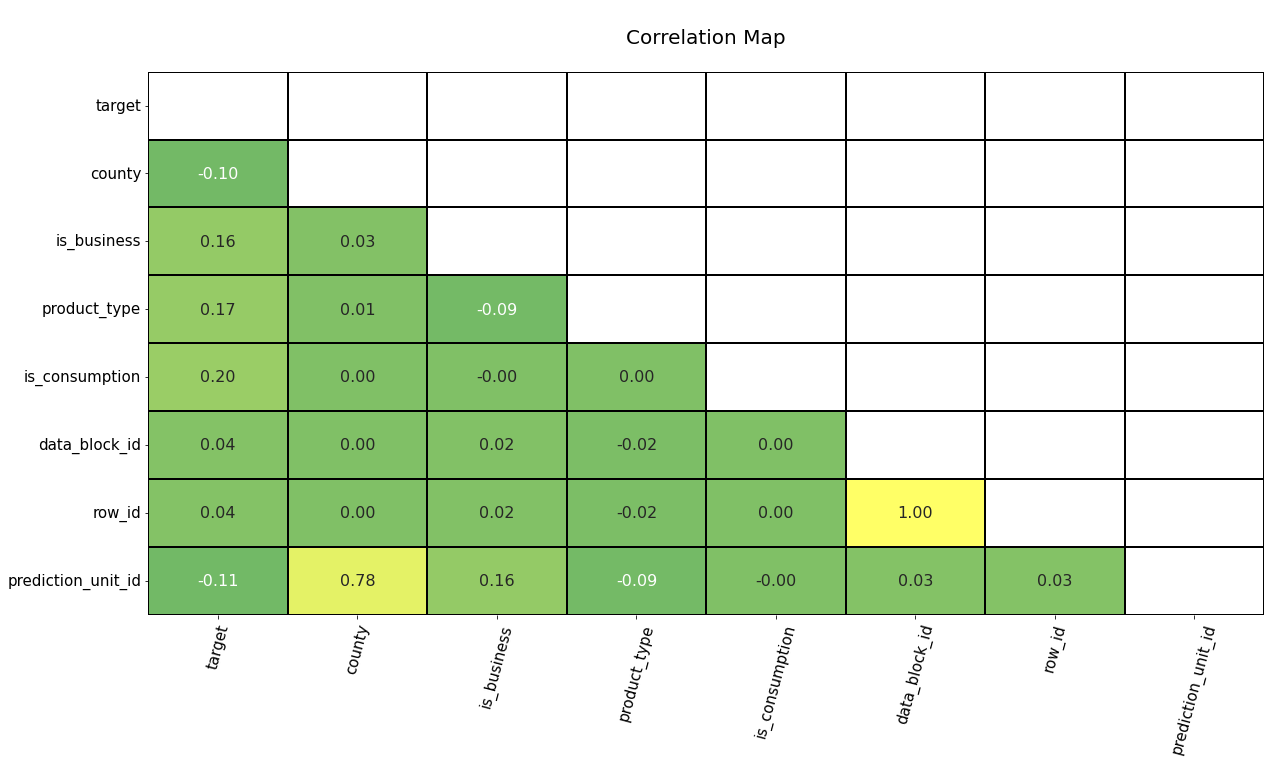

In [25]:
features = train[['county', 'is_business', 'product_type', 'target', 'is_consumption', 'data_block_id', 'row_id', 'prediction_unit_id']]
ordered_features = ['target'] + [col for col in features.columns if col != 'target']
features = features[ordered_features]

corr_map(features, width=20, height=10, annot_kws=16)

In [19]:
missing_values_table(train)

        n_miss  ratio
target     528  0.030


In [29]:
duplicated_rows(train)

Number of Duplicated Rows: 0

Duplicated first 5 Rows:


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
